# Prior analysis

To analyse which breaks in roughness trends are likely to be attributed to human intervention, we run an analysis with some prior distribution for the vegetation model. Let's first import all necessary data

In [1]:
from srm.data import StreamData
from srm.models import SrmParameters, FrictionModel, get_pmc_model
import numpy as np 
import json
from srm.common import SetPlotStyle
from importlib import reload
import srm.models as sm
import matplotlib.pyplot as plt

# Load data
data = StreamData(f'../../data/test_stream_01/streamdata/section_i_data.json')



2021-04-26 10:52    INFO     0% T+ 0.07s Loaded ../../data/test_stream_01/streamdata/section_i_data.json


Next, we define some help functions that will help us analyse the data

In [22]:
def plot_prior_analysis(periods, data, year, legend:bool=True, plotday:int=0):
    """ Plots the timeseries with some prior distribution of parameters
    """
    
    fig, axs = plt.subplots(3, figsize=(12, 12), dpi=150)
    for i, period in enumerate(periods):
        
        # set data for period
        data.set_mask(years=[int(year)], days=range(period[0], period[1]))
    
        n = 2000 # amount of 
        
        # Set priors
        # --------------------
        
        # Time maximal growth. At daynr 160 for first period. 
        # Otherwise we prior it in between
        if i == 0:
            tmg = 160
        else:
            tmg = (period[1] - period[0])/2 + period[0]
        
        # Priors
        param_prior = SrmParameters(
            amax=np.random.normal(0.16, scale=0.02, size=n),                       
            rg=np.random.normal(0.06, scale=0.01, size=n),
            tmg=np.random.normal(tmg, scale=20, size=n),
            nb=np.random.normal(0.04, scale=0.01, size=n), 
            n=n,
            varsigma=np.random.normal(0.04, scale=0.01, size=n)
                                   )

        
        # run model with prior dist.
        sf = sm.FrictionModel(data=data, param=param_prior)
        
        # plot period
        sf.plot(ax=axs[0])

        axs[2].plot(data.daynumbers, data.discharge, '-k')
        axs[2].set_ylabel('Afvoer [m$^3$s$^{-1}$]')
        axs[2].set_xlabel("Dagnummer")
        
        axs[1].plot(data.daynumbers, data.manning - np.mean(sf.output[1], axis=1), '.c')
        axs[1].set_ylabel("Priore afwijking")
    
    # clean up plot
    axs[0].set_ylim([0, 0.6])
    axs[1].plot([0, 365], [0, 0], '-k')
    axs[0].plot([plotday, plotday], [0, 0.6], '-b')
    for ax in axs:
        ax.set_xlim([0, 365])
        ylim = ax.get_ylim()

        for i in range(0, 370, 10):
            ax.plot([i]*2, ylim, '--k', linewidth=0.5)

        for period in periods:
            ax.plot([period[0]]*2, ylim, '-r', linewidth=2)
            ax.plot([period[1]]*2, ylim, '-r', linewidth=2)
        ax.set_ylim(ylim)
    SetPlotStyle(fig, legendbelow=False, legend=False)


## Plot without periods

For this example we'll look at the year 2015. First we define a dictionary without any period breaks, then visualise the prior distribution

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


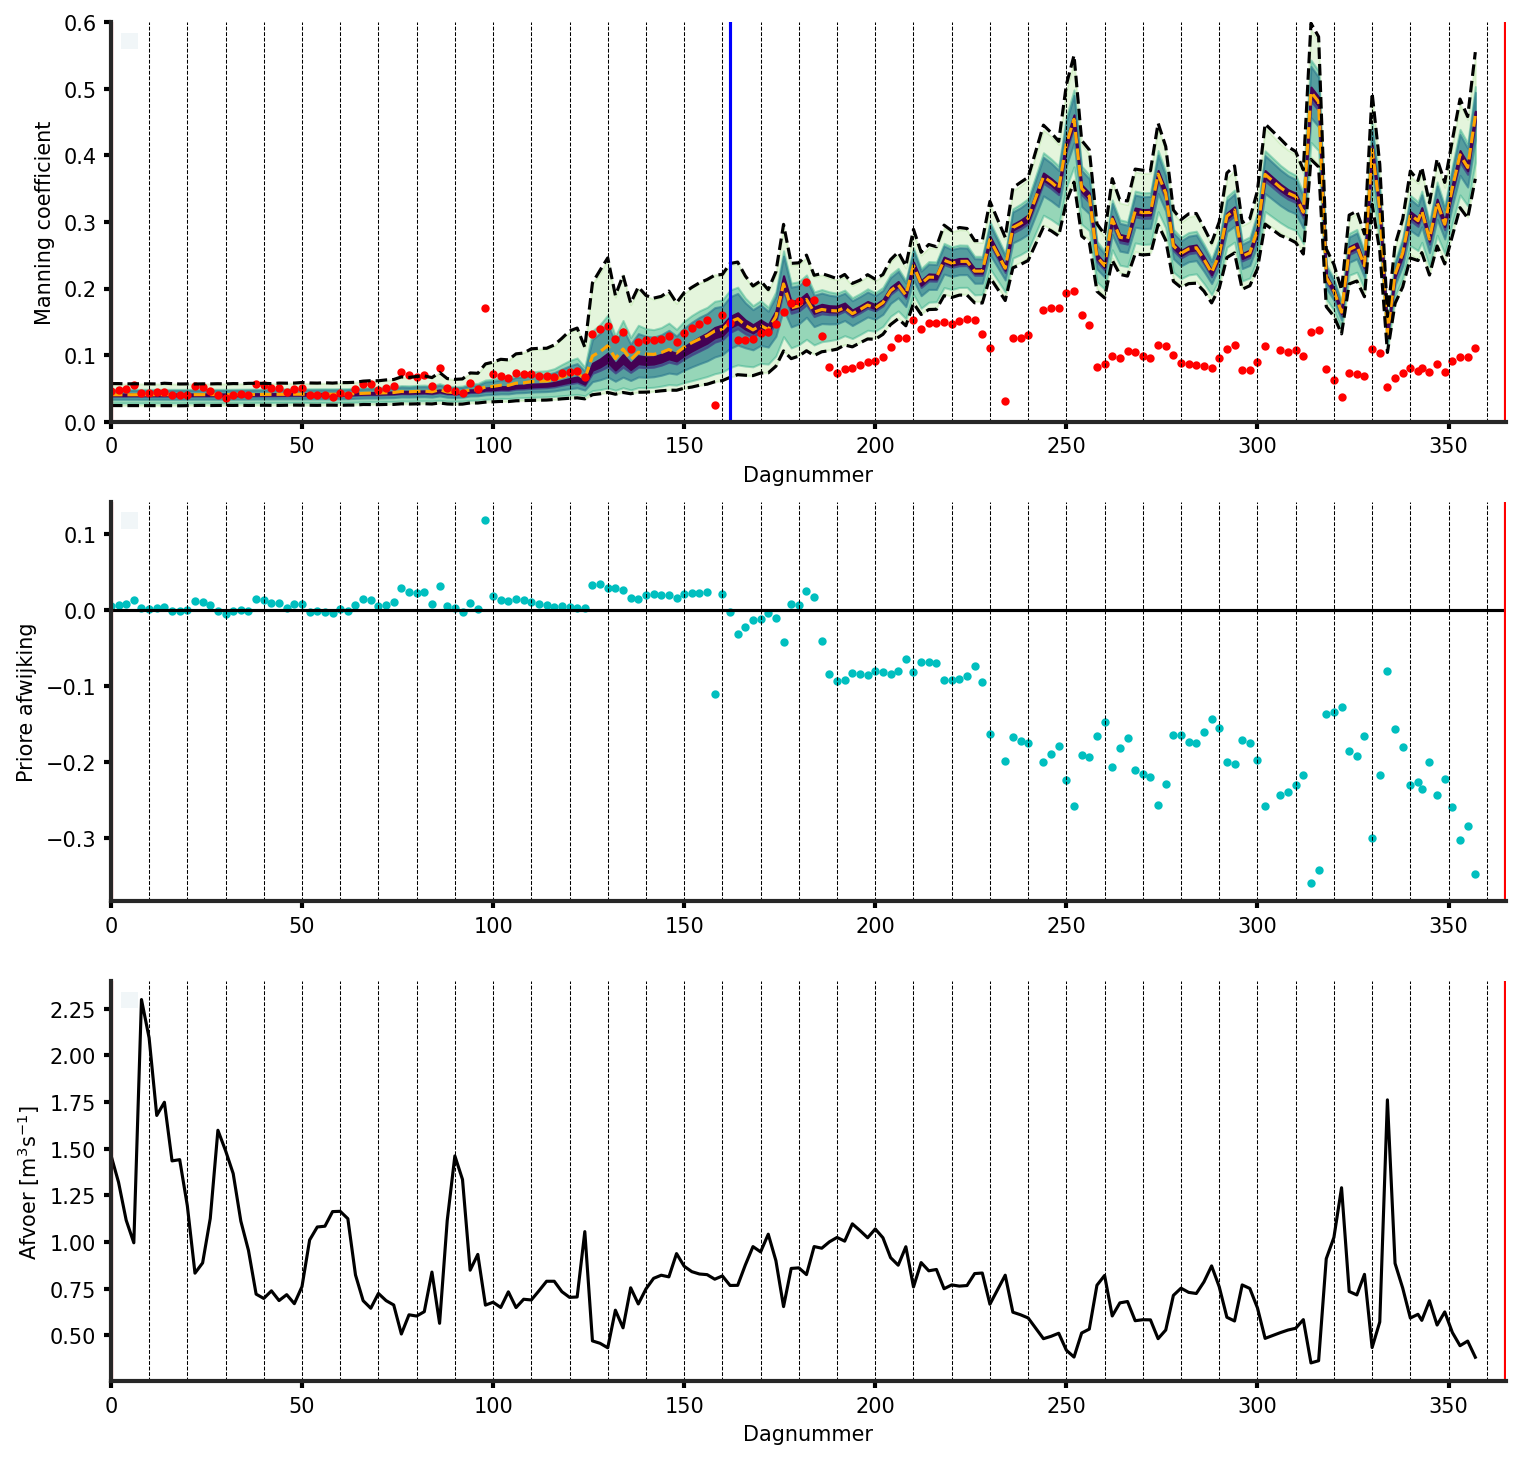

In [23]:
periods =  {'2005':((0, 365),),
             '2006':((0, 365),),
             '2007':((0, 365),),
             '2008':((0, 365),),
             '2009':((0, 365),),
             '2010':((0, 365),),
             '2011':((0, 365),),
             '2012':((0, 365),),
             '2014':((0, 365),),
             '2015':((0, 365),),
             '2016':((0, 365),),
             '2017':((0, 365),),
             '2018': ((0, 365),),
             '2019': ((0, 365),),
             '2020': ((0, 365),),
            }


plot_prior_analysis(periods.get('2015'), data, year=2015, plotday=162)

plt.savefig('prior_analysis_no_periods.png')

In the above figure we clearly see that around day 162, the roughness suddenly drops and does not immediately recover (shown by blue line). Since the priod predictive model cannot model it, this is not due to discharge. According to our assumptions, then it must be due to a sudden change in vegetation.  

## Identify periods

Let's identify the first periods and see how the model then fares. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


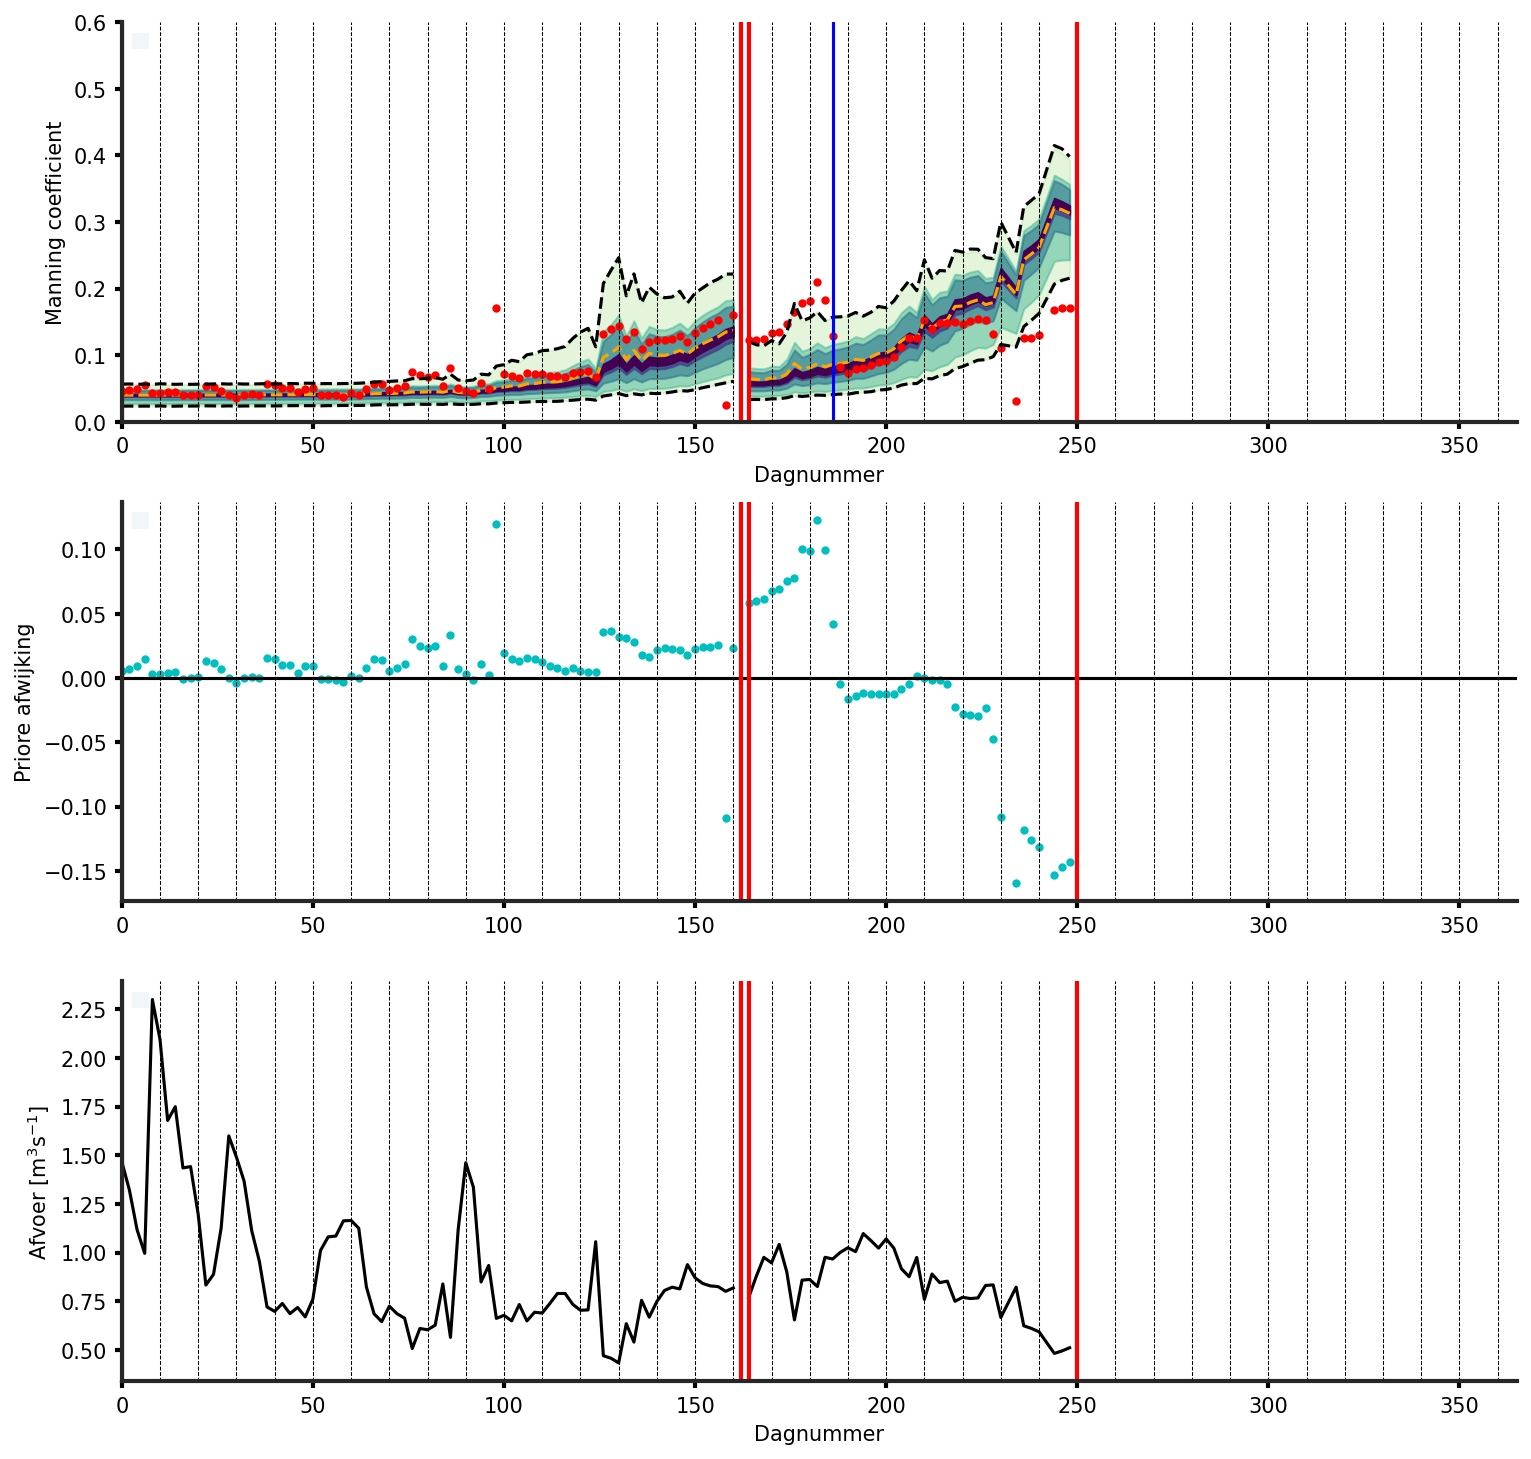

In [26]:
# Now we have two periods
periods['2015'] = ((0, 162), (164, 250)) 

# Plot 
plot_prior_analysis(periods.get('2015'), data, year=2015, plotday=186)
plt.savefig(f'prior_analysis_with_two_periods.png')

This is better, but we clearly see that there is another break around day 186. Let's add a few more periods in this way until we're sure we found them all.  

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


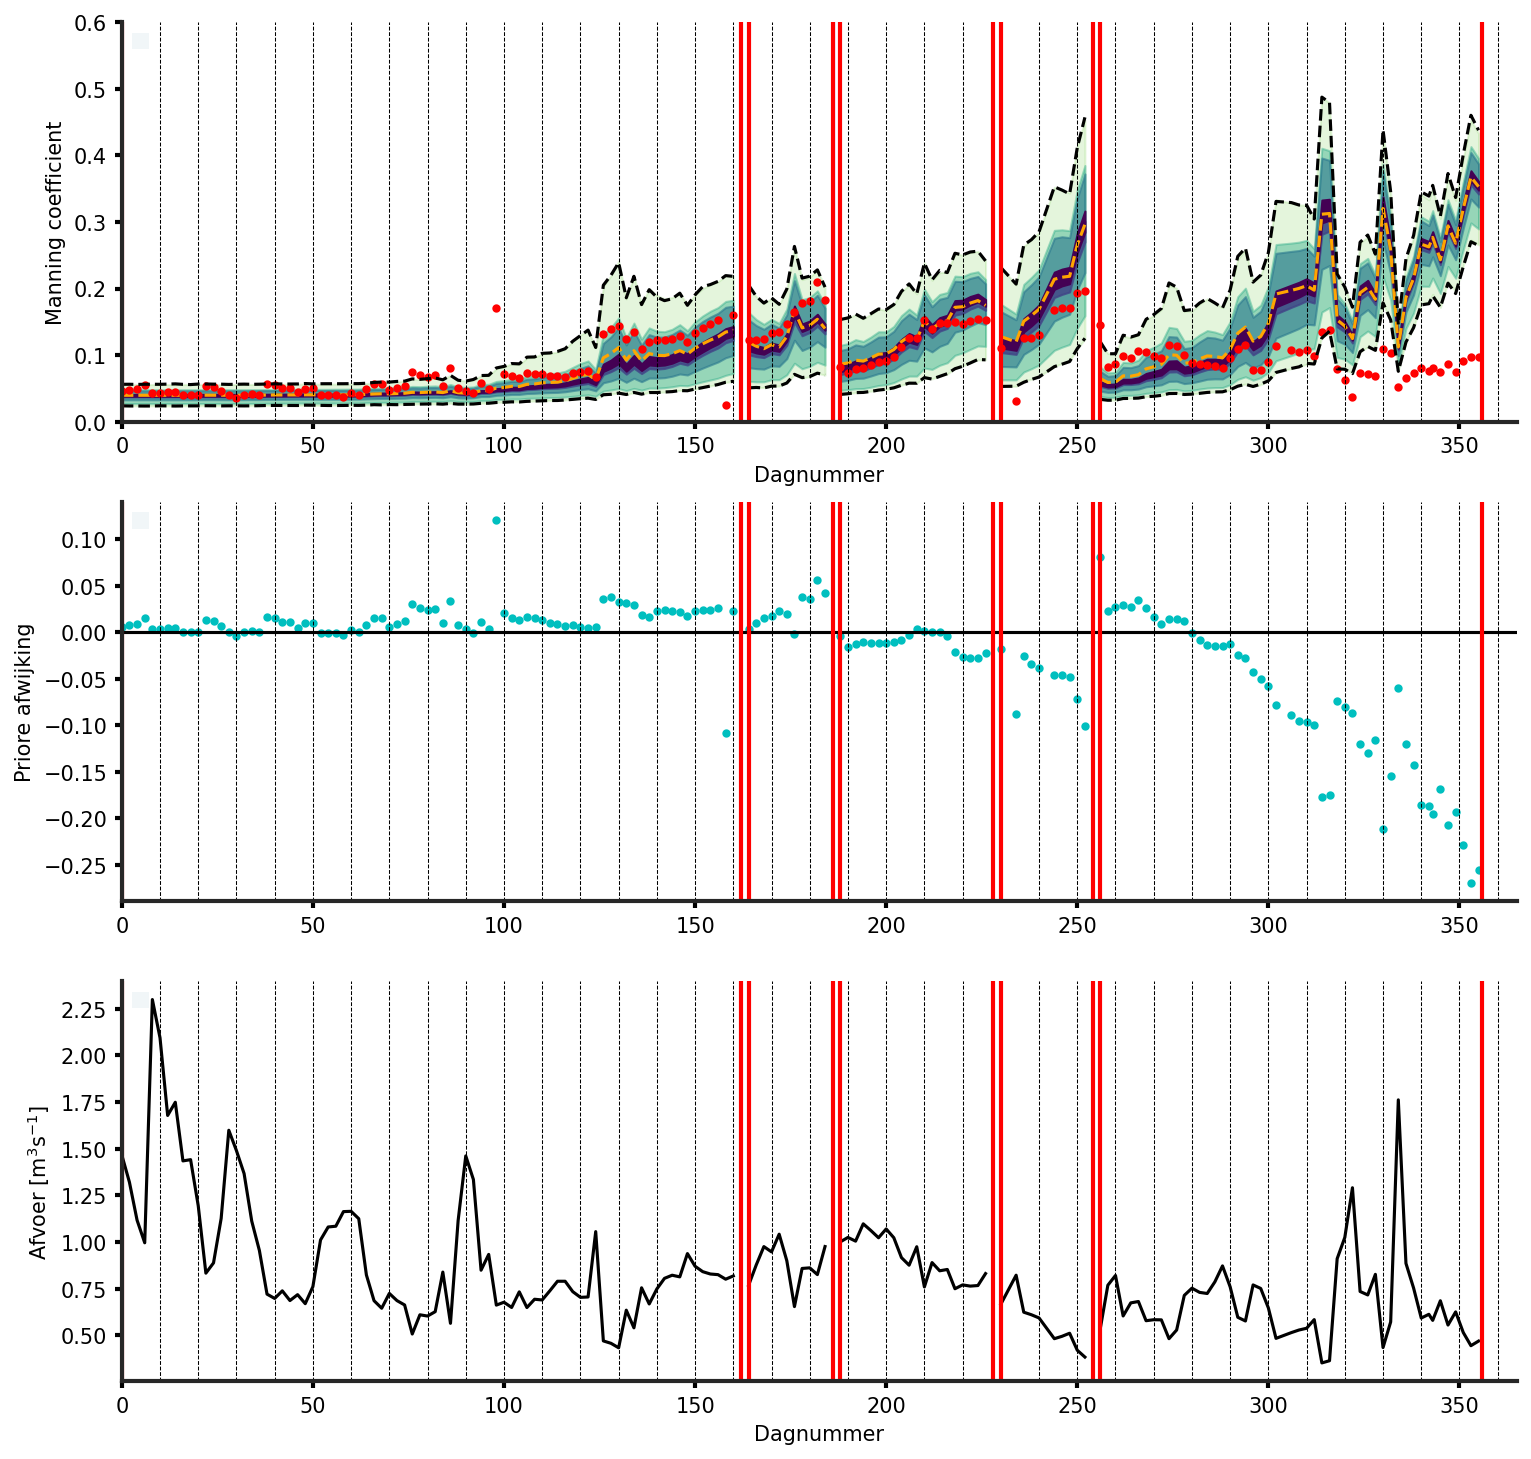

In [28]:
periods['2015'] = ((0, 162), (164, 186), (188, 228), (230, 254), (256, 356)) 

# Plot 
plot_prior_analysis(periods.get('2015'), data, year=2015, plotday=186)
plt.savefig(f'prior_analysis_with_all_periods.png')

Note that in the last period the model predicts a rising roughness but the data shows a constant roughness. This is to be expected: the growth season is at an end and no vegetation exists at this point. With the periods identify, let's print out a list of the dates that belong to this daynumbers:

In [31]:
from datetime import datetime, timedelta

for year in periods:
    for i, period in enumerate(periods.get(year)):
        if (i == 0) & (period[0] !=0):
            date = datetime(year=int(year), month=1, day=1) + timedelta(days=period[0])
            print (f"{date.strftime('%d-%b-%Y')}")    
            if period[-1] !=365: 
                date = datetime(year=int(year), month=1, day=1) + timedelta(days=period[1])
                print (f"{date.strftime('%d-%b-%Y')}")    
        elif period[-1] != 365:
            date = datetime(year=int(year), month=1, day=1) + timedelta(days=period[1])
            print (f"{date.strftime('%d-%b-%Y')}, (period {i})")
        

12-Jun-2015, (period 0)
06-Jul-2015, (period 1)
17-Aug-2015, (period 2)
12-Sep-2015, (period 3)
23-Dec-2015, (period 4)
